In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [5]:
#load dataset
df = pd.read_csv('D:/Downlord/int_test.csv')

In [6]:
#Dataframe dimension
df.shape

(35116, 8)

In [7]:
df.head(100)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
...,...,...,...,...,...,...,...,...
95,536532,84375,SET OF 20 KIDS COOKIE CUTTERS,24,12/1/10 13:24,2.10,12433.0,Norway
96,536532,22966,GINGERBREAD MAN COOKIE CUTTER,24,12/1/10 13:24,1.25,12433.0,Norway
97,536532,21874,GIN AND TONIC MUG,24,12/1/10 13:24,1.25,12433.0,Norway
98,536532,21873,IF YOU CAN'T STAND THE HEAT MUG,24,12/1/10 13:24,1.25,12433.0,Norway


In [8]:
#Check Missing data
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [9]:
# Only keep transactions with CustomerID's
df =df[df.CustomerID.notnull()]

In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [11]:
df.CustomerID.head()

0    12583.0
1    12583.0
2    12583.0
3    12583.0
4    12583.0
Name: CustomerID, dtype: float64

In [12]:
# Convert customer ID's into integers
df['CustomerID'] = df.CustomerID.astype(int)

In [13]:
# Create 'Sales' interaction feature
df['Sales'] = df['Quantity']*df['UnitPrice']
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

# Customer-level feature engineering

In [14]:
# Aggegrate invoice data
invoice_data = df.groupby('CustomerID').agg(
    total_transactions=('InvoiceNo','nunique'))

print(invoice_data)

            total_transactions
CustomerID                    
12347                        7
12348                        4
12349                        1
12350                        1
12352                        8
...                        ...
17444                        3
17508                        1
17828                        4
17829                        1
17844                        1

[414 rows x 1 columns]


In [15]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)
print(product_data)

            total_products  total_unique_products
CustomerID                                       
12347                  182                    103
12348                   31                     22
12349                   73                     73
12350                   17                     17
12352                   85                     59
...                    ...                    ...
17444                  135                    132
17508                   22                     22
17828                   67                     54
17829                   30                     30
17844                    5                      5

[414 rows x 2 columns]


In [16]:
#Aggregate sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('Sales','sum'),
    avg_product_value=('Sales', 'mean')
)
print(sales_data)

            total_sales  avg_product_value
CustomerID                                
12347           4310.00          23.681319
12348           1797.24          57.975484
12349           1757.55          24.076027
12350            334.40          19.670588
12352           2506.04          29.482824
...                 ...                ...
17444           2940.04          21.778074
17508            387.31          17.605000
17828           1820.09          27.165522
17829            889.24          29.641333
17844             51.56          10.312000

[414 rows x 2 columns]


In [17]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583,France,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583,France,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583,France,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583,France,10.2
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583,France,15.6


# Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [18]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data =df.groupby(['CustomerID','InvoiceNo']).agg(
    cart_value=('Sales','sum')
)
print(cart_data)

                      cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
...                          ...
17828      557668          30.00
           563936         213.50
           576897         743.43
17829      543911         889.24
17844      564428          51.56

[1536 rows x 1 columns]


In [19]:
#Reset index
cart_data.reset_index(inplace=True)

cart_data

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,475.39
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,584.91
...,...,...,...
1531,17828,557668,30.00
1532,17828,563936,213.50
1533,17828,576897,743.43
1534,17829,543911,889.24


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

In [20]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value','mean'),
    min_cart_value=('cart_value','min'),
    max_cart_value=('cart_value','max')
)
agg_cart_data

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,615.714286,224.82,1294.32
12348,449.310000,227.44,892.80
12349,1757.550000,1757.55,1757.55
12350,334.400000,334.40,334.40
12352,313.255000,120.33,840.30
...,...,...,...
17444,980.013333,550.94,1217.64
17508,387.310000,387.31,387.31
17828,455.022500,30.00,833.16


In [21]:
# Join together customer-level data
customer_df = invoice_data.join([product_data,sales_data,agg_cart_data])
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.

**Very Important:** We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [22]:
# Save analytical base table
customer_df.to_csv('D:/SLIIT/extra ml projects/analytical_base_table.csv')

# Curse of Dimensionality.

In [23]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583


In [25]:
item_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33698 entries, 0 to 35115
Columns: 2575 entries, 10002 to CustomerID
dtypes: int32(1), uint8(2574)
memory usage: 83.1 MB


In [26]:
# Create item_data by aggregating at customer level
item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


In [27]:
# Total times each item was purchased
item_data.sum()

10002       12
10120        1
10125       13
10133        5
10135        4
          ... 
90202D       1
90204        1
C2           6
M           34
POST      1055
Length: 2574, dtype: int64

In [28]:
# Save item_data.csv
item_data.to_csv('D:/SLIIT/extra ml projects/item_data.csv')

## Method 1 - Thresholding
One very simple and straightforward way to reduce the dimensionality of this item data is to set a threshold for keeping features.
To make this concrete, assume we only wish to keep item features for the 20 most popular items.

In [29]:
popular_items = item_data.sum().sort_values(ascending=False).head(20)
popular_items

POST      1055
22326      271
22423      222
22554      197
22556      179
21731      169
22328      166
22629      160
22551      158
21212      143
20725      141
23084      140
20750      132
20719      128
85099B     123
20726      123
21080      122
22139      117
22630      115
22961      114
dtype: int64

In [30]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(120).index

top_20_items

Index(['22748', '22847', '15056BL', '23159', '85014B', '23243', '23231',
       '22898', '23388', '23255',
       ...
       '21212', '22551', '22629', '22328', '21731', '22556', '22554', '22423',
       '22326', 'POST'],
      dtype='object', length=120)

In [31]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

item_data

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17444,0,0,0,2,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17508,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17828,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [32]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('D:/SLIIT/extra ml projects/threshold_item_data.csv')

# Using PCA


In [33]:
# Read item_data.csv
item_data = pd.read_csv('D:/SLIIT/extra ml projects/item_data.csv', index_col=0)

In [36]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display  rows of item_data_scaled
item_data_scaled[:]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       ...,
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.12065146],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072]])

In [41]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)
# Generate new features
PC_items = pca.transform(item_data_scaled)
PC_items

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05, -1.55431223e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04, -1.26704203e-14],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  4.97692165e-15],
       ...,
       [-5.21816182e+00,  3.64837894e+00,  2.50643421e+00, ...,
         2.97765229e-04, -2.14214577e-06, -4.13558077e-15],
       [-4.93612992e+00,  3.02167496e+00, -1.50715580e+00, ...,
         3.14242326e-04, -3.98525350e-05,  8.32667268e-17],
       [-6.04237234e+00, -2.91369265e-01, -6.74022034e-01, ...,
        -2.36796029e-02,  3.91626698e-04,  2.46677678e-15]])

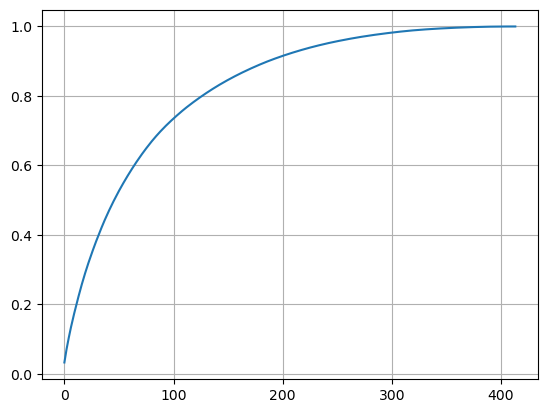

In [42]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

In [43]:
#This chart is saying: To capture about 98% of the variance, we'd need to 
# keep around 300 components.
cumulative_explained_variance[300]

0.9824241831916607

In [47]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)

In [48]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,10.603071,1.239909,3.086324,5.336237,-0.410776,1.616712,-6.383660,3.065176,...,0.079858,-0.401015,-0.214117,0.004822,0.119369,-0.262572,-0.207354,-0.202242,-0.163557,-0.115927,0.181271,-0.095161,-0.105527,-0.212449,-0.103296,0.159956,0.069231,-0.008045,0.180137,-0.270089,-0.167042,0.006650,0.101338,-0.050800,-0.063129,-0.041142,-0.075494,0.004294,0.048200,0.024264,0.116425,-0.034355,-0.214043,0.055005,-0.036463,0.030752,0.140117,0.098891,-0.053586,0.080197,-0.008415,0.021794,-0.079847,0.073096,0.054393,0.086940,-0.071187,-0.119354,0.036222,0.056827
12348,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054586,0.499987,0.373514,1.226616,-0.773072,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580828,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396417,0.154925,0.333479,-0.466261,0.703453,1.200580,-0.202163,-0.871793,-0.055068,-0.421734,-1.623012,-0.397689,0.452590,...,0.081330,1.068196,-0.384246,-1.069483,0.851032,1.001910,-0.384887,-0.413079,0.677065,-0.275448,1.214939,-1.133653,1.058974,-0.840926,0.351597,1.301284,-0.145225,0.366761,-0.336522,0.198578,0.599954,-0.319961,-0.636518,0.348992,-0.873909,0.596575,1.143346,0.757113,-0.000742,0.529100,-0.902432,-0.278414,0.353742,0.276582,-0.197176,-0.169993,-0.421457,0.336172,0.808099,0.831984,-0.669350,-0.076403,0.128035,-0.100001,0.275367,-0.618979,0.396646,-0.950562,0.439322,0.825360
12349,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090829,-0.095243,-0.163216,0.700639,1.381549,-0.243735,-0.105134,-0.176475,0.862919,1.685211,...,-0.598545,0.172718,-0.249292,-0.383961,0.919607,-0.541221,0.642578,0.192422,1.071443,-0.530992,0.199431,-0.170188,0.423062,0.281394,-0.059589,-0.491435,-0.338918,0.797088,0.445545,-0.060347,0.165299,-0.274593,0.093971,0.027958,0.083388,0.121201,0.137503,0.022743,-0.194177,0.567623,-0.066405,0.265952,-0.508799,-0.104120,0.419699,-0.055255,0.469271,-0.155029,-0.470380,0.792076,0.352519,-0.290933,0.059804,0.343069,0.649156,0.125700,0.306267,-0.114499,-0.590520,-0.388614
12350,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364748,0.178124,-0.260398,-0.168826,-0.681953,1.081304,-0.155239,-0.397164,0.240051,0.634068,-1.447081,-0.186097,-0.315379,-0.306429,-1.359020,-0.001475,0.579057,-0.248313,0.588130,-0.217988,0.284600,0.525267,-0.531670,-0.101393,

In [49]:
# Save pca_item_data.csv
items_pca.to_csv('D:/SLIIT/extra ml projects/pca_item_data.csv')

# KMeans Clustering

In [50]:
# Import analytical base table
base_df = pd.read_csv('D:/SLIIT/extra ml projects/analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('D:/SLIIT/extra ml projects/threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('D:/SLIIT/extra ml projects/pca_item_data.csv', index_col=0)

In [51]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 120)
(414, 300)


Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.**

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features ("Base DF")
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF")
3. Purchase pattern features + principal component features from items ("PCA DF")

Create a threshold_df by joining base_df with threshold_item_data.

In [52]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [53]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985884,-1.464059,...,0.079858,-0.401015,-0.214117,0.004822,0.119369,-0.262572,-0.207354,-0.202242,-0.163557,-0.115927,0.181271,-0.095161,-0.105527,-0.212449,-0.103296,0.159956,0.069231,-0.008045,0.180137,-0.270089,-0.167042,0.006650,0.101338,-0.050800,-0.063129,-0.041142,-0.075494,0.004294,0.048200,0.024264,0.116425,-0.034355,-0.214043,0.055005,-0.036463,0.030752,0.140117,0.098891,-0.053586,0.080197,-0.008415,0.021794,-0.079847,0.073096,0.054393,0.086940,-0.071187,-0.119354,0.036222,0.056827
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054586,0.499987,0.373514,1.226616,-0.773072,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580828,0.949802,-0.733970,0.353890,-0.387479,-0.298542,0.396417,0.154925,0.333479,-0.466261,0.703453,...,0.081330,1.068196,-0.384246,-1.069483,0.851032,1.001910,-0.384887,-0.413079,0.677065,-0.275448,1.214939,-1.133653,1.058974,-0.840926,0.351597,1.301284,-0.145225,0.366761,-0.336522,0.198578,0.599954,-0.319961,-0.636518,0.348992,-0.873909,0.596575,1.143346,0.757113,-0.000742,0.529100,-0.902432,-0.278414,0.353742,0.276582,-0.197176,-0.169993,-0.421457,0.336172,0.808099,0.831984,-0.669350,-0.076403,0.128035,-0.100001,0.275367,-0.618979,0.396646,-0.950562,0.439322,0.825360
12349,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090829,-0.095243,...,-0.598545,0.172718,-0.249292,-0.383961,0.919607,-0.541221,0.642578,0.192422,1.071443,-0.530992,0.199431,-0.170188,0.423062,0.281394,-0.059589,-0.491435,-0.338918,0.797088,0.445545,-0.060347,0.165299,-0.274593,0.093971,0.027958,0.083388,0.121201,0.137503,0.022743,-0.194177,0.567623,-0.066405,0.265952,-0.508799,-0.104120,0.419699,-0.055255,0.469271,-0.155029,-0.470380,0.792076,0.352519,-0.290933,0.059804,0.343069,0.649156,0.125700,0.306267,-0.114499,-0.590520,-0.388614
12350,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305371,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364748,0.178124,-0.260398,-0.168826,-0.681953,1.081304,-0.155239,-0.397164,0.240051,0.634068,-1.447081,-0.186097,-0.315379,-0.306429,-1.359020,-0.001475,0.579

In [54]:
# Initialize instance of StandardScaler
t_scaler = StandardScaler()
p_scaler = StandardScaler()

# Fit and transform
threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [76]:
t_kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 123)

In [77]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

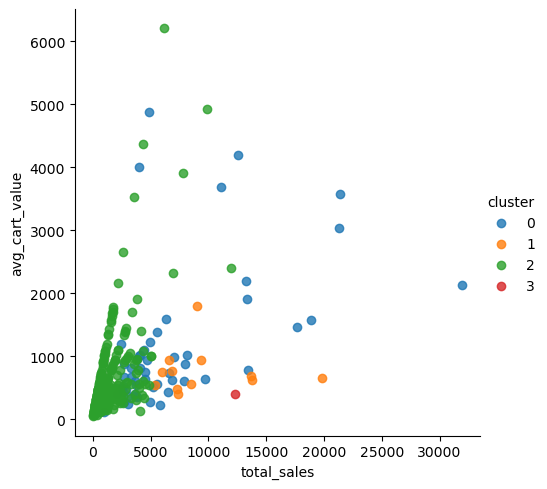

In [78]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

K-Means with pca_df

In [79]:
p_kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 123)

In [80]:
p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

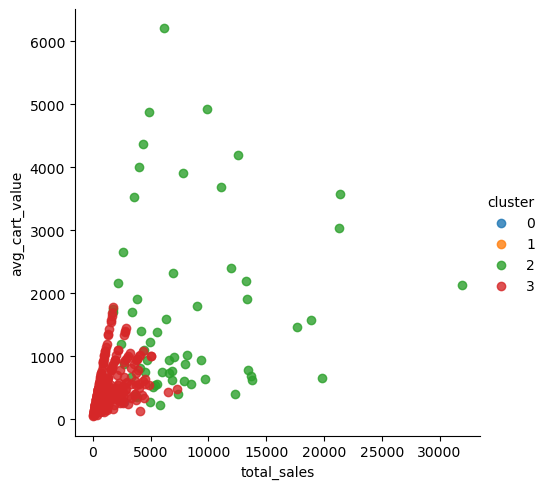

In [81]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [82]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.6115738094305558